# Optimized BERT Model for Tamil Language Identification (Using Class Weights)
## Challenging Experiment

###### Faculty: Dr. Ratnavel Rajalakshmi
###### Slot: L33+L34 (G1 Slot)
###### Course: CSE3506: Essentials of Data Analytics

<br>

| Name | Register Number | Branch |
| :-- | :--: | --: |
| Hariket Sukesh Kumar Sheth (Team Leader) | 20BCE1975 | CSE Core |
| Manasvi Maheshwari | 20BAI1032 | CSE AI & ML |
| Suraj Shah | 20BRS1122 | CSE Robotics |


> - Content moderation is imperative in social media platforms to support healthy online discussions. 
> - However, though multiple existing works identify offensive content in code-mixed Dravidian languages, they are only restricted to classifying whole comments without identifying part of content contributing to offensiveness. 
> - Such restriction is primarily due to the lack of annotated data for offensive spans in code-mixed Dravidian languages. 
> - In this shared task, we provide code-mixed social media text for Tamil language with offensive spans for which the participants are expected to develop systems.

### Peforming checks for the resources available

In [5]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: Tesla T4


### Installing huggingface transformers library

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.6 MB/s eta 0:00:00


### Importing drive into the colaboratory

In [8]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


### Importing dataset directories

In [9]:
from os import getcwd , listdir 
from os.path import join
curr_dir = getcwd()
drive_dir = join(curr_dir , 'drive','MyDrive')
dataset_dir = join(drive_dir,'Codalab','Offensive Language Detection','Dataset')

In [10]:
listdir(dataset_dir)

['tamil_offensive_full_train.csv',
 'tamil_offensive_full_test.csv',
 'tamil_offensive_full_dev.csv',
 'tamil_offensive_full_train_corrected.csv',
 'tamil_offensive_full_dev_corrected.csv']

### Loading training data

In [11]:
import pandas as pd
import numpy as np 
import random

from os import getcwd , listdir 
from os.path import join

train_df_path = join(dataset_dir,'tamil_offensive_full_train_corrected.csv')
# Load the dataset into a pandas dataframe.
df = pd.read_csv(train_df_path)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 35,139



,text,label
8814,Jeyam ravi maari vandhu nippanu patha nilalhal...,Not_offensive
18196,Bollywood ka bap Kon hai Tollibood,Not_offensive
31012,Tamil cinema 2000 vaati adici tovaca athe kath...,Offensive_Untargetede
3148,Indian + LKG + Ayan...,Not_offensive
1505,ஜாதி பேர் செல்லி நம்மை அடிநினைஜாதிவெறி நாய்களு...,Not_offensive
16051,THALAIVAR POLITICAL ENTRY - dei..! ithu 96'....,Offensive_Targeted_Insult_Group
17123,"SK kadhai mudiyum neram, Santhanam rocks, evan...",Offensive_Targeted_Insult_Individual
8365,Yuvan bgmleh thalaiya pakka mothe innu vera l...,Not_offensive
1163,அனைத்து சாதி தலைவர்களும் சாதியை வைத்து வசதியாக...,Not_offensive
17938,Ennada 10M views ku 5th day laye ivlo mukkudhu...,Offensive_Untargetede


In [12]:
df['label'].value_counts()

Not_offensive                           25425
Offensive_Untargetede                    2906
Offensive_Targeted_Insult_Group          2557
Offensive_Targeted_Insult_Individual     2343
not-Tamil                                1454
Offensive_Targeted_Insult_Other           454
Name: label, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [14]:
df['label'].value_counts()

0    25425
4     2906
1     2557
2     2343
5     1454
3      454
Name: label, dtype: int64

### Loading `train_sentences` and `train_labels`

In [15]:
# Get the lists of sentences and their labels.
train_sentences = df['text'].values
train_labels = df['label'].values

### Handling class imbalance using `sklearn's comput_class_weight`

In [16]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[ 0.23034415  2.29037935  2.4995732  12.89977974  2.01531315  4.0278542 ]


### Helper Functions

#### 1) Update Interval Function

In [17]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [19]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


#### 4) Function for calculating weighted f1 score

In [20]:
def f1_score_func(preds, labels,average):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average=average,labels = np.unique(preds_flat))

#### 5) Function for calculating accuracy per class

In [21]:
def accuracy_per_class(preds, labels , label_dict):
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

## Smart Batching of the training data

In [22]:
from transformers import AutoTokenizer

model_name = 'bert-base-multilingual-uncased'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading bert-base-multilingual-uncased tokenizer...


In [23]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))       
    

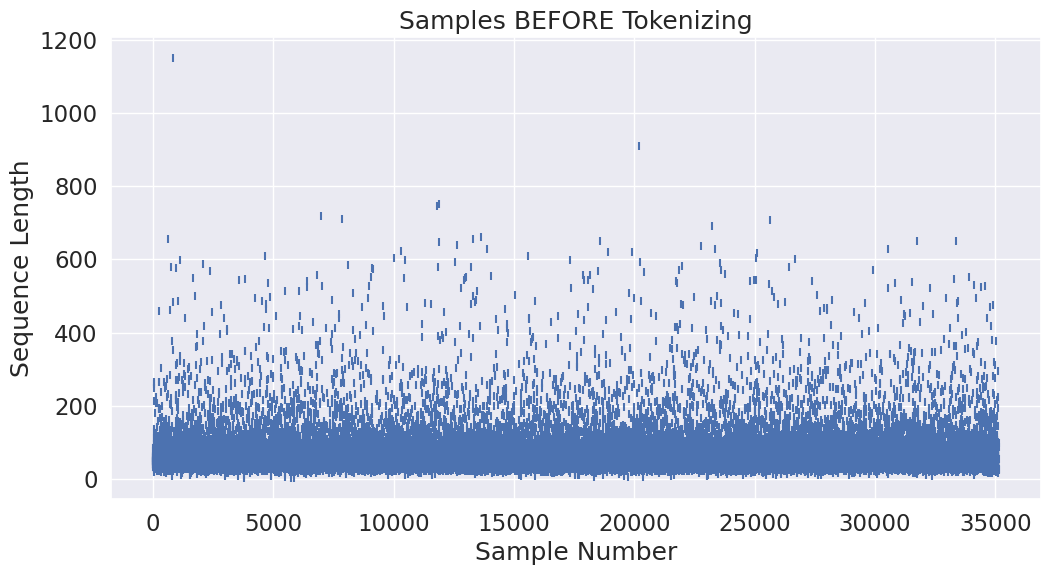

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [25]:
max_input_length = 512

In [26]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:
    
    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,           
                                 add_special_tokens=True, 
                                 max_length=max_input_length,  
                                 truncation=True,     
                                 padding=False)       
                                 
    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)
    
print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 35,139 training samples...
  Tokenized 0 samples.
  Tokenized 4,000 samples.
  Tokenized 8,000 samples.
  Tokenized 12,000 samples.
  Tokenized 16,000 samples.
  Tokenized 20,000 samples.
  Tokenized 24,000 samples.
  Tokenized 28,000 samples.
  Tokenized 32,000 samples.
DONE.
    35,139 samples


In [27]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

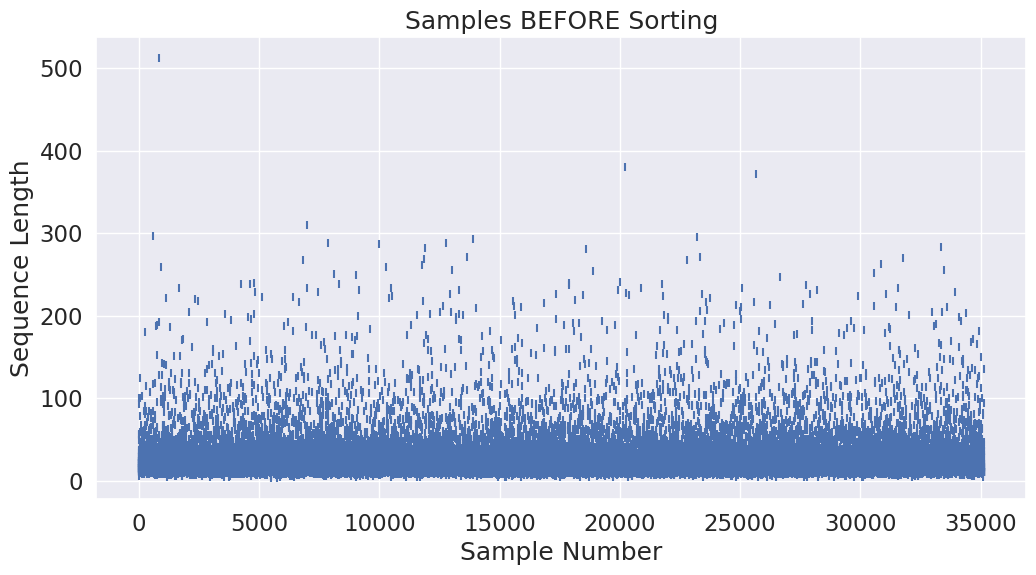

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [29]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [30]:
train_samples[0:5]

[([101, 90569, 102], 0),
 ([101, 12050, 102], 0),
 ([101, 12278, 11424, 102], 0),
 ([101, 12278, 26895, 102], 0),
 ([101, 17141, 17141, 102], 0)]

In [31]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 512


In [32]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

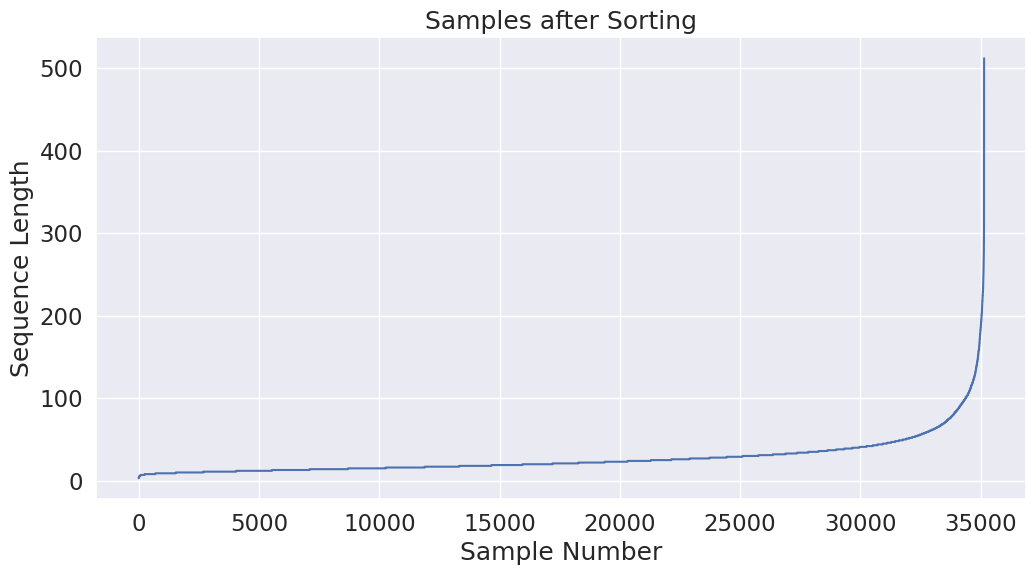

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [34]:
train_samples[0]

([101, 90569, 102], 0)

In [35]:
batch_size = 16

In [36]:
import random

# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...    
while len(train_samples) > 0:
    
    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until 
    # we get to the last batch, which may be smaller. 
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of 
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.
  Selected 500 batches.
  Selected 600 batches.
  Selected 700 batches.
  Selected 800 batches.
  Selected 900 batches.
  Selected 1,000 batches.
  Selected 1,100 batches.
  Selected 1,200 batches.
  Selected 1,300 batches.
  Selected 1,400 batches.
  Selected 1,500 batches.
  Selected 1,600 batches.
  Selected 1,700 batches.
  Selected 1,800 batches.
  Selected 1,900 batches.
  Selected 2,000 batches.
  Selected 2,100 batches.

  DONE - 2,197 batches.


In [37]:
print(batch_ordered_sentences[0])

[[101, 21292, 13113, 10709, 20639, 11807, 13113, 10709, 21292, 10112, 20639, 102], [101, 10103, 53945, 15618, 10112, 25767, 10206, 17141, 25577, 10544, 43257, 102], [101, 10743, 151, 13168, 123, 10167, 11531, 10139, 44657, 14160, 12810, 102], [101, 18844, 90569, 40046, 54979, 10709, 11498, 11801, 95502, 10335, 94030, 102], [101, 23145, 17172, 91345, 12459, 14543, 12947, 10237, 35956, 28913, 12459, 102], [101, 16998, 10112, 10141, 10708, 29602, 21292, 10947, 17526, 10544, 43257, 102], [101, 151, 21506, 85404, 10115, 10934, 53641, 10127, 35854, 11767, 119, 102], [101, 10695, 10125, 16153, 112, 161, 15415, 122, 73513, 11210, 86899, 102], [101, 25767, 10206, 32531, 10115, 10222, 40046, 10335, 40046, 10335, 10141, 102], [101, 15048, 19864, 117, 15454, 68809, 117, 11628, 40046, 10335, 19864, 102], [101, 10237, 10417, 12674, 17612, 12577, 11169, 18465, 70533, 12851, 13113, 102], [101, 12367, 10150, 13563, 10202, 47410, 25984, 10112, 14478, 10112, 136, 102], [101, 32821, 62678, 26010, 10115, 1

In [38]:
batch_ordered_labels[0]

[3, 0, 0, 3, 5, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0]

### Padding

In [39]:
import torch

py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []
    
    # First, find the longest sample in the batch. 
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:
        
        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [40]:
# Get the new list of lengths after sorting.
import numpy as np
padded_lengths = []

# For each batch...
for batch in py_inputs:
    
    # For each sample...
    for s in batch:
    
        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 17,991,168
  Smart Batching: 990,032  (94.5% less)


#### Load the model configuration from the transformers library using AutoConfig

In [41]:
from transformers import AutoConfig

# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=4)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



#### Load the model from the transformers library using AutoModel

In [42]:
from transformers import AutoModel

# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [43]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

#### Creating a custom BERT model 

In [44]:
import torch.nn as nn
class BERT_Model(nn.Module):
    ## defining the constructor for the class
    def __init__(self, bert,num_labels):
      ## calling the super class constructor
      super(BERT_Model, self).__init__()
      ## adding the bert layer to the model
      self.bert = bert        
      # relu activation function
      self.relu =  nn.ReLU()
      # adding a dense layer to our custom model
      self.fc1 = nn.Linear(768,512)
      # adding another dense layer to our custom model ,i.e., the Output layer
      self.fc2 = nn.Linear(512,num_labels)
      # adding a softmax  activation function for our custom model's output layer
      self.softmax = nn.LogSoftmax(dim=1)

    #defining the forward pass
    def forward(self, input_id, mask):
      #pass the inputs to the model  
      outputs = self.bert(input_id,mask)
  
      last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
      pooler_output = outputs.pooler_output               ## pooler output from the model
      ## adding a fully connected layer to the BERT model
      x = self.fc1(pooler_output)
      ## applying relu activation function
      x = self.relu(x)
      # the final output layer
      x = self.fc2(x)
      # apply softmax activation to our output layer
      x = self.softmax(x)

      return x

In [45]:
import torch

print('\nLoading model ...')
# pass the pre-trained BERT to our define architecture
model = BERT_Model(bert,num_labels=6)

model.cuda()


Loading model ...


BERT_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

### Custom Loss function

In [46]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 


In [47]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import random
import numpy as np
import time

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the 
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)
    
    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        preds = model(b_input_ids, b_input_mask)
        
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, b_labels)
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training on 2,197 batches...
  Batch     200  of    2,197.    Elapsed: 0:00:09.  Remaining: 0:01:28
  Batch     400  of    2,197.    Elapsed: 0:00:15.  Remaining: 0:01:07
  Batch     600  of    2,197.    Elapsed: 0:00:21.  Remaining: 0:00:56
  Batch     800  of    2,197.    Elapsed: 0:00:27.  Remaining: 0:00:47
  Batch   1,000  of    2,197.    Elapsed: 0:00:33.  Remaining: 0:00:40
  Batch   1,200  of    2,197.    Elapsed: 0:00:39.  Remaining: 0:00:33
  Batch   1,400  of    2,197.    Elapsed: 0:00:45.  Remaining: 0:00:26
  Batch   1,600  of    2,197.    Elapsed: 0:00:51.  Remaining: 0:00:19
  Batch   1,800  of    2,197.    Elapsed: 0:00:58.  Remaining: 0:00:13
  Batch   2,000  of    2,197.    Elapsed: 0:01:04.  Remaining: 0:00:06

  Average training loss: 1.76
  Training epoch took: 0:01:10

======== Epoch 2 / 4 ========
Creating Smart Batches from 35,139 examples with batch size 16...

Tokenizing 35,139 samples...
  Tokenized 0 samples.
  Tokenized 4,000 

#### Loading the validation data

In [ ]:
val_df_path = join(dataset_dir,'tamil_offensive_full_dev_corrected.csv')
# Load the dataset into a pandas dataframe.
df = pd.read_csv(val_df_path)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 4,388



,text,label
3476,Thala mass Thala thala thala thala thala thala,Not_offensive
736,Vera Level . Bairava 2017 sema hit movie in ...,Not_offensive
1014,எல்லாரும் மனுசங்க தான அப்புறம் எப்படி ஜாத...,Not_offensive
2138,Enga annan sethuvala padam hit akum,Not_offensive
3685,Bigil illa ma game aa.. . Hahahhaha,Not_offensive
2921,24-07-2019 - 11:38 pm anybody here?,Not_offensive
668,Serupadiii goes to thevidiyaa paiyaa kurumaa v...,Offensive_Targeted_Insult_Individual
1502,70 vayasuku yeththa nadippaa ithu..nee vera le...,Not_offensive
4256,waaaooow chiyan semmmee sir...unga look n your...,Not_offensive
999,Draupathi 2 kandippa varanum innoru unmai samp...,Not_offensive


#### Loading `test_sentences` and `test_labels`

In [ ]:
df['label'] = le.transform(df['label'])

In [ ]:
test_sentences = df['text'].values 
test_labels = df['label'].values

In [ ]:
# Use our new function to completely prepare our dataset.
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(test_sentences, test_labels, batch_size ,tokenizer,max_input_length)

Creating Smart Batches from 4,388 examples with batch size 16...

Tokenizing 4,388 samples...
  Tokenized 0 samples.
  Tokenized 400 samples.
  Tokenized 800 samples.
  Tokenized 1,200 samples.
  Tokenized 1,600 samples.
  Tokenized 2,000 samples.
  Tokenized 2,400 samples.
  Tokenized 2,800 samples.
  Tokenized 3,200 samples.
  Tokenized 3,600 samples.
  Tokenized 4,000 samples.
DONE.
     4,388 samples

     4,388 samples after sorting

Creating batches of size 16...

  DONE - Selected 275 batches.

Padding out sequences within each batch...
  DONE.


#### Making predictions on our test dataset

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_labels)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# Put model in evaluation mode
model.eval()

# For each batch of training data...
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        steps_per_sec = (time.time() - t0) / step
        remaining_sec = steps_per_sec * (len(py_inputs) - step)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

    # Copy the batch to the GPU.
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, b_input_mask)

    logits = outputs

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,388 test sentences...
  Batch      30  of      275.    Elapsed: 0:00:01.  Remaining: 0:00:06
  Batch      60  of      275.    Elapsed: 0:00:02.  Remaining: 0:00:06
  Batch      90  of      275.    Elapsed: 0:00:02.  Remaining: 0:00:05
  Batch     120  of      275.    Elapsed: 0:00:03.  Remaining: 0:00:04
  Batch     150  of      275.    Elapsed: 0:00:04.  Remaining: 0:00:03
  Batch     180  of      275.    Elapsed: 0:00:05.  Remaining: 0:00:02
  Batch     210  of      275.    Elapsed: 0:00:05.  Remaining: 0:00:02
  Batch     240  of      275.    Elapsed: 0:00:06.  Remaining: 0:00:01
  Batch     270  of      275.    Elapsed: 0:00:07.  Remaining: 0:00:00
    DONE.


### Evaluating accuracy over test set

In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.800


#### Classification report of our predictions

In [ ]:
class_names = ['Not_offensive', 'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual',  'Offensive_Targeted_Insult_Other','Offensive_Untargetede','not-Tamil']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(preds,true_labels , target_names=class_names))

                                      precision    recall  f1-score   support

                       Not_offensive       0.78      0.75      0.77      3311
     Offensive_Targeted_Insult_Group       0.34      0.12      0.18       822
Offensive_Targeted_Insult_Individual       0.09      0.16      0.12       175
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00         0
               Offensive_Untargetede       0.04      0.16      0.06        80
                           not-Tamil       0.00      0.00      0.00         0

                            accuracy                           0.60      4388
                           macro avg       0.21      0.20      0.19      4388
                        weighted avg       0.66      0.60      0.62      4388



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
label_dict = {0:'Not_offensive', 1:'Offensive_Targeted_Insult_Group', 2:'Offensive_Targeted_Insult_Individual',  3:'Offensive_Targeted_Insult_Other',
              4:'Offensive_Untargetede',5:'not-Tamil'}

In [ ]:
accuracy_per_class(predictions, true_labels , label_dict)

Class: Not_offensive
Accuracy: 78.01

Class: Offensive_Targeted_Insult_Group
Accuracy: 33.56

Class: Offensive_Targeted_Insult_Individual
Accuracy: 9.12

Class: Offensive_Targeted_Insult_Other
Accuracy: 0.0

Class: Offensive_Untargetede
Accuracy: 3.65

Class: not-Tamil
Accuracy: 0.0



In [ ]:
torch.save(model,"./drive/MyDrive/Codalab/Offensive Language Detection/Models/BERT_Multilingual_Tamil_Optimized_Using_Class_Weights")

In [ ]:
from sklearn.metrics import f1_score
f1_score_func(predictions,true_labels,average='macro')

0.2797665698216571

## Loading the model

In [65]:
model = torch.load('./drive/MyDrive/Codalab/Offensive Language Detection/Models/BERT_Tamil_Optimized_Using_Class_Weights_RANLP2023',map_location=device)

In [66]:
model.cuda()

BERT_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

## Making Predictions on Test Set

In [67]:
test_df_path = join(dataset_dir,'tamil_offensive_full_test.csv')
test_df = pd.read_csv(test_df_path,sep='\t')

In [68]:
test_df

,text
0,14.12.2018 epo trailer pathutu irken ... Semay...
1,Paka thana poro movie la Enna irukunu
2,“U kena tunggu lebih lama lagi untuk tahu saya...
3,Suriya anna vera level anna mass
4,suma kaththaatha da sound over a pooda kudaath...
...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...
4388,Babu mele ko ye song sunke kuch yesa feel hua ...
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...
4390,Vijay's all movies look like same.


## Loading `test_sentences`

In [69]:
test_sentences = test_df['text'].values 
test_ids = test_df.index.values

In [70]:
test_ids

array([   0,    1,    2, ..., 4389, 4390, 4391])

In [71]:
test_sentences

array(['14.12.2018 epo trailer pathutu irken ... Semaya iruku',
       'Paka thana poro movie la Enna irukunu',
       '“U kena tunggu lebih lama lagi untuk tahu saya” - chiyaan recognized',
       ...,
       'asuran= aadukalam+pudupettai+ wada chennai..yellame ore madirida...',
       "Vijay's all movies look like same.",
       'Eh Idhu 96, yaara emathuringa.. Bangam ji Bangam ji'],
      dtype=object)

In [72]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 4,392 examples with batch size 16...

Tokenizing 4,392 samples...
  Tokenized 0 samples.
  Tokenized 400 samples.
  Tokenized 800 samples.
  Tokenized 1,200 samples.
  Tokenized 1,600 samples.
  Tokenized 2,000 samples.
  Tokenized 2,400 samples.
  Tokenized 2,800 samples.
  Tokenized 3,200 samples.
  Tokenized 3,600 samples.
  Tokenized 4,000 samples.
DONE.
     4,392 samples

     4,392 samples after sorting

Creating batches of size 16...

  DONE - Selected 275 batches.

Padding out sequences within each batch...
  DONE.


## Evaluating accuracy over test set

In [74]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs 

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 275 test batches...
  Batch      30  of      275.    Elapsed: 0:00:01.  Remaining: 0:00:11
  Batch      60  of      275.    Elapsed: 0:00:03.  Remaining: 0:00:10
  Batch      90  of      275.    Elapsed: 0:00:04.  Remaining: 0:00:07
  Batch     120  of      275.    Elapsed: 0:00:05.  Remaining: 0:00:07
  Batch     150  of      275.    Elapsed: 0:00:06.  Remaining: 0:00:05
  Batch     180  of      275.    Elapsed: 0:00:07.  Remaining: 0:00:04
  Batch     210  of      275.    Elapsed: 0:00:08.  Remaining: 0:00:02
  Batch     240  of      275.    Elapsed: 0:00:08.  Remaining: 0:00:01
  Batch     270  of      275.    Elapsed: 0:00:09.  Remaining: 0:00:00


In [75]:
print(y_preds)

[0 0 1 ... 0 0 0]


In [76]:
print(y_ids)

[3237 3247 3487 ...    1 1347  499]


In [77]:
le.inverse_transform(y_preds)

array(['Not_offensive', 'Not_offensive',
       'Offensive_Targeted_Insult_Group', ..., 'Not_offensive',
       'Not_offensive', 'Not_offensive'], dtype=object)

<Axes: xlabel='count'>

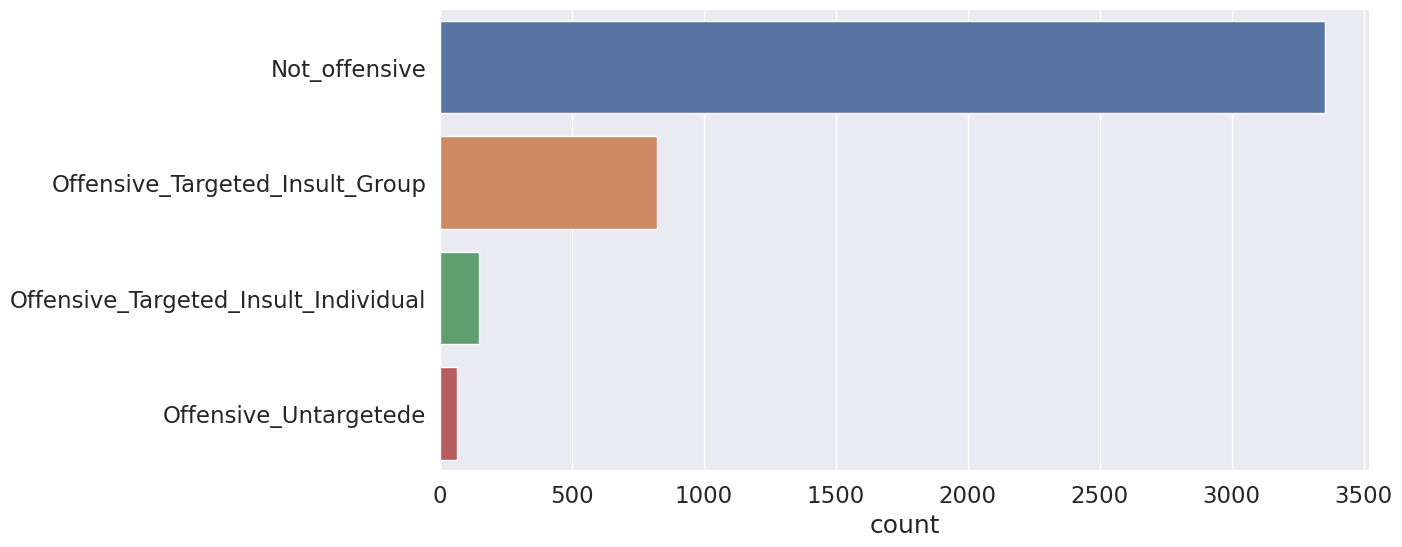

In [78]:
sns.countplot(y =le.inverse_transform(y_preds))

In [79]:
len(y_ids)

4392

In [80]:
len(le.inverse_transform(y_preds))

4392

## Creating Submission DataFrame

In [81]:
df_new = pd.DataFrame({
    'id':y_ids,
    'label':le.inverse_transform(y_preds)
})

In [82]:
test_df['id'] = test_df.index

In [83]:
df_new

,id,label
0,3237,Not_offensive
1,3247,Not_offensive
2,3487,Offensive_Targeted_Insult_Group
3,3544,Not_offensive
4,3791,Not_offensive
...,...,...
4387,4327,Not_offensive
4388,4335,Not_offensive
4389,1,Not_offensive
4390,1347,Not_offensive


In [84]:
test_df

,text,id
0,14.12.2018 epo trailer pathutu irken ... Semay...,0
1,Paka thana poro movie la Enna irukunu,1
2,“U kena tunggu lebih lama lagi untuk tahu saya...,2
3,Suriya anna vera level anna mass,3
4,suma kaththaatha da sound over a pooda kudaath...,4
...,...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,4387
4388,Babu mele ko ye song sunke kuch yesa feel hua ...,4388
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,4389
4390,Vijay's all movies look like same.,4390


In [85]:
df_f = pd.merge(test_df,df_new,on = 'id')
df_f

,text,id,label
0,14.12.2018 epo trailer pathutu irken ... Semay...,0,Not_offensive
1,Paka thana poro movie la Enna irukunu,1,Not_offensive
2,“U kena tunggu lebih lama lagi untuk tahu saya...,2,Not_offensive
3,Suriya anna vera level anna mass,3,Not_offensive
4,suma kaththaatha da sound over a pooda kudaath...,4,Offensive_Targeted_Insult_Individual
...,...,...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,4387,Not_offensive
4388,Babu mele ko ye song sunke kuch yesa feel hua ...,4388,Not_offensive
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,4389,Not_offensive
4390,Vijay's all movies look like same.,4390,Offensive_Targeted_Insult_Group


In [86]:
df_f = df_f[['id','text','label']]
df_f

,id,text,label
0,0,14.12.2018 epo trailer pathutu irken ... Semay...,Not_offensive
1,1,Paka thana poro movie la Enna irukunu,Not_offensive
2,2,“U kena tunggu lebih lama lagi untuk tahu saya...,Not_offensive
3,3,Suriya anna vera level anna mass,Not_offensive
4,4,suma kaththaatha da sound over a pooda kudaath...,Offensive_Targeted_Insult_Individual
...,...,...,...
4387,4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,Not_offensive
4388,4388,Babu mele ko ye song sunke kuch yesa feel hua ...,Not_offensive
4389,4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,Not_offensive
4390,4390,Vijay's all movies look like same.,Offensive_Targeted_Insult_Group


## Saving Submission DataFrame

In [87]:
path = './drive/MyDrive/Codalab/Offensive Language Detection/SubmissionFiles'

In [89]:
df_f.to_csv(join(path,'optimised_bert_tamil.csv'),index=False)